In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])



In [ ]:
calendar= pd.read_csv('/content/gdrive/My Drive/Kaggle/calendar.csv')
prices= pd.read_csv('/content/gdrive/My Drive/Kaggle/sell_prices.csv')
#sales_train_evaluation= pd.read_csv('/content/gdrive/My Drive/Kaggle/sales_train_evaluation.csv')

In [ ]:
sales_train_validation=pd.read_csv('/content/gdrive/My Drive/Kaggle/sales_train_validation.csv')

Since this is a deep learning model, The use of GPU will accelerate the training. The first models are not so demanding so you can still use CPU training (but it will be slower).

# Pytorch Approach

In [ ]:
import numpy as np
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales_train_evaluation[col] = 0
    sales_train_evaluation[col] = sales_train_evaluation[col].astype(np.int16)

In [ ]:
sales_bd = np.round(sales_train_evaluation.memory_usage().sum()/(1024*1024),1)
#calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
#Downcast in order to save memory
def transform (df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        '''elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')'''
    return df  

sales_train_evaluation = transform(sales_train_evaluation)
prices = transform(prices)
calendar = transform(calendar)
sales_train_validation = transform(sales_train_validation)

In [ ]:
sales_ad = np.round(sales_train_validatio.memory_usage().sum()/(1024*1024),1)
#calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
 print('Sales train evaluation has {} rows and {} columns'.format(sales_train_evaluation.shape[0], sales_train_evaluation.shape[1]))

Sales train evaluation has 30490 rows and 1947 columns


In [ ]:
 print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))


Sales train validation has 30490 rows and 1919 columns


Here we create dates list, that will help later on to display the Time Series, with the right dates



In [ ]:
#Create date index
date_index = calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

**Select one time series as an example**

In [ ]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation['item_store_id'] = sales_train_validation.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


In [ ]:
#Select arbitrary index and plot the time series
index = 321
y = pd.DataFrame(DF_Sales.iloc[:,index])
TS_selected = y 
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='black')

plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )
plt.legend(fontsize=10)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 18)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 15)
plt.xlabel(xlabel = 'Date',fontsize = 15)
plt.show()

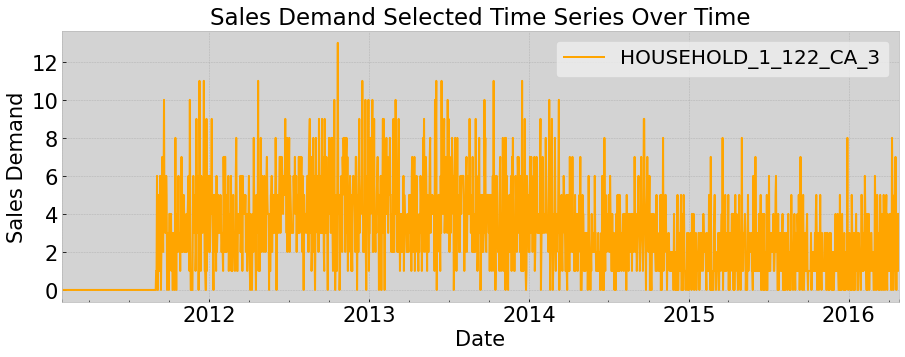

In [ ]:
#Select arbitrary index and plot the time series
index = 6780
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(15, 5),color='orange')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )
plt.legend(fontsize=15)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 18)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 15)
plt.xlabel(xlabel = 'Date',fontsize = 15)
plt.show()

In [ ]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [ ]:
#Mentioned for seq to seq

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [ ]:
#normalizing the data
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))


In [ ]:
#if we print some values we can see values are between -1 and 1
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[-0.53846154]
 [-0.38461538]
 [-0.84615385]
 [-0.84615385]
 [-0.38461538]]


Plot the distribution before and after the Normalization. As you can see, we kept the distribution of the data, but we change its scales.

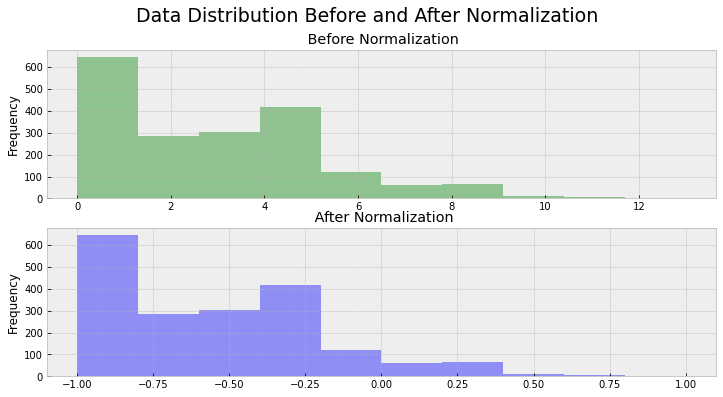

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='green') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

Create Sequences

The Basic idea of Time Series prediction and RNN (Recurrent Neural Network) is to re-arrange the data into windows of sequences, and labels.

In this part we allign the data into input features and labels with techniches which adapt for Time series processing.

We create a sliding window which builds sequences and labels. In our case, we have sequences of 28 days, that will use to predict the next day.

In [ ]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [ ]:
#train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


**Pytorch Tensors**

Pytorch use tensors as the input to the model Variable is a wrapper to the tensor.I use the Variable wrapper A more common way is to train with batches and use the dataset class


In [ ]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 1])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 1])
test label shape is: torch.Size([622, 1])


So we got :

1262 sets of 28 samples each as the features (X) and 1262 labels as our target(y) in the training set
622 sets of 28 samples with 622 labels in our tests set
You can see that in Pytorch the tensor dimensions are opposite to the NumPy dimensions

# **Pytorch Simple LSTM model**

The following parameters are provided to the net

Num-classes - is the number of output in this case 1

Input size - we don't use batch, so we have one input (of 28 samples)

Hidden layers, number of hidden layer in each cell, the more is better, but also will slow down the training

Num layers - we have one layer of LSTM (layer we will increase it)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [ ]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
device='cuda:0'

In [ ]:
#####  Parameters  ######################
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.41975 valid loss:  0.45443 
Epoch: 50, loss: 0.15492 valid loss:  0.09401 
Epoch: 100, loss: 0.16139 valid loss:  0.10588 
Epoch: 150, loss: 0.16322 valid loss:  0.08583 
Epoch: 200, loss: 0.15459 valid loss:  0.09647 
Epoch: 250, loss: 0.16054 valid loss:  0.09137 
Epoch: 300, loss: 0.14796 valid loss:  0.08949 
Epoch: 350, loss: 0.15578 valid loss:  0.10884 
Epoch: 400, loss: 0.16188 valid loss:  0.09590 
Epoch: 450, loss: 0.14626 valid loss:  0.09789 


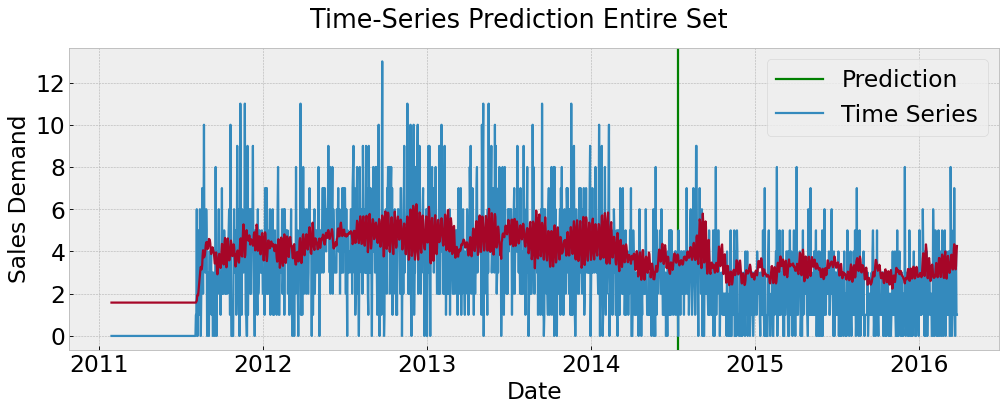

In [ ]:
######Prediction on entire dataset###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='g')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

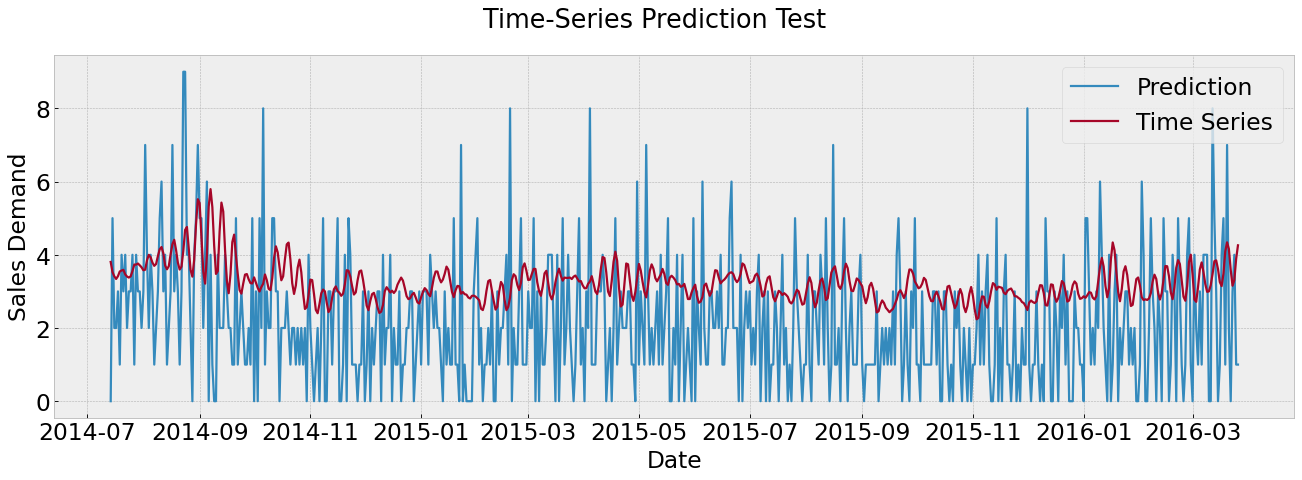

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


**Test RMSE**

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

# Multiple LSTM

We can Enhance the net by using multiple LSTM layers.

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
num_epochs = 700
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.38336 valid loss:  0.06890 
Epoch: 50, loss: 0.10149 valid loss:  0.07262 
Epoch: 100, loss: 0.09888 valid loss:  0.07043 
Epoch: 150, loss: 0.09767 valid loss:  0.07164 
Epoch: 200, loss: 0.09677 valid loss:  0.07145 
Epoch: 250, loss: 0.09575 valid loss:  0.07160 
Epoch: 300, loss: 0.09533 valid loss:  0.07173 
Epoch: 350, loss: 0.09443 valid loss:  0.07178 
Epoch: 400, loss: 0.09482 valid loss:  0.07192 
Epoch: 450, loss: 0.09431 valid loss:  0.07195 
Epoch: 500, loss: 0.09460 valid loss:  0.07197 
Epoch: 550, loss: 0.09453 valid loss:  0.07199 
Epoch: 600, loss: 0.09451 valid loss:  0.07197 
Epoch: 650, loss: 0.09439 valid loss:  0.07196 


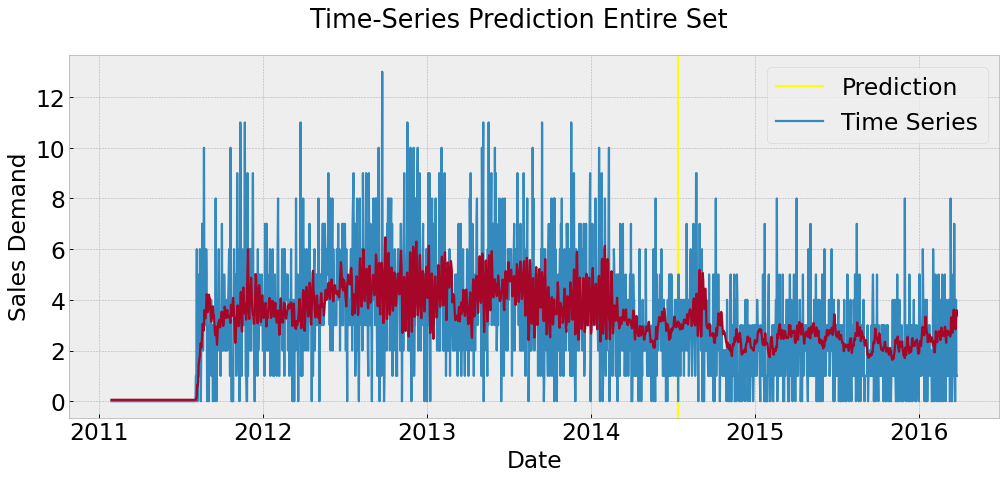

In [ ]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='yellow')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

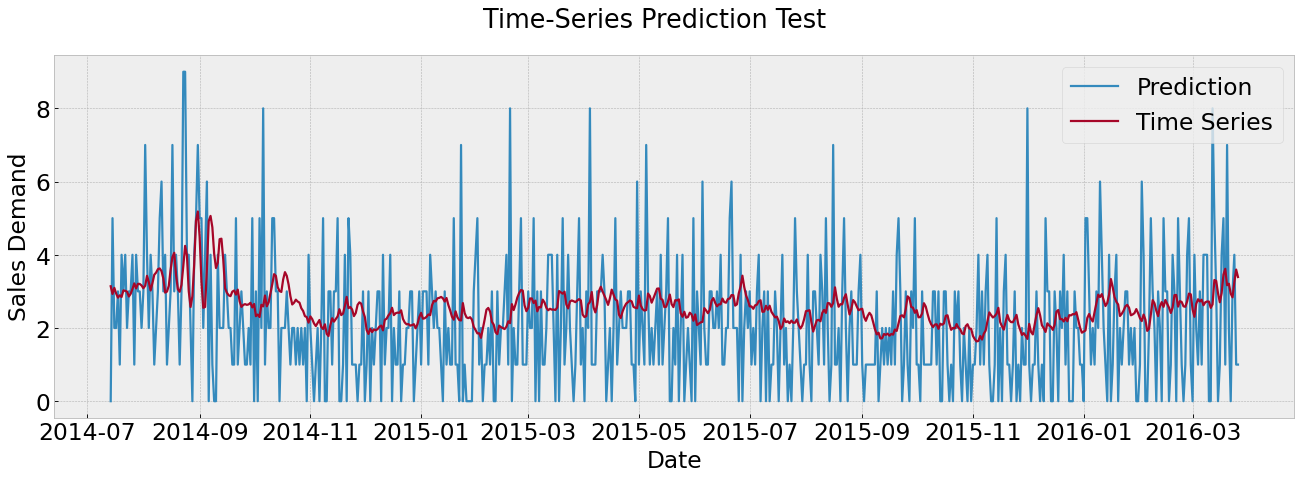

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='K')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

RMSE

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

1.7437088

# Add Features



So far we add only one feature - The Sales demand Now let's add more features

Features can be lags or rolling windows. It is easier to implement using data-frame.
 Lag is just shifting the sales demand.

 Let's start again with the selected Time Series, Add some features and modify a bit our model and training.

In [ ]:
# Re-Use the Time Series we have selected earlier
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

,sales
2016-04-20,3
2016-04-21,4
2016-04-22,1
2016-04-23,1
2016-04-24,4


In [ ]:
#Lag Features
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
0.00 min: Time for bulk shift


**Plot Lags**
Let's Plot our lags it is a bit hard to see the small lags (as the Time Series containing few years), but for the longer lags such as 365, we can see the shift ...

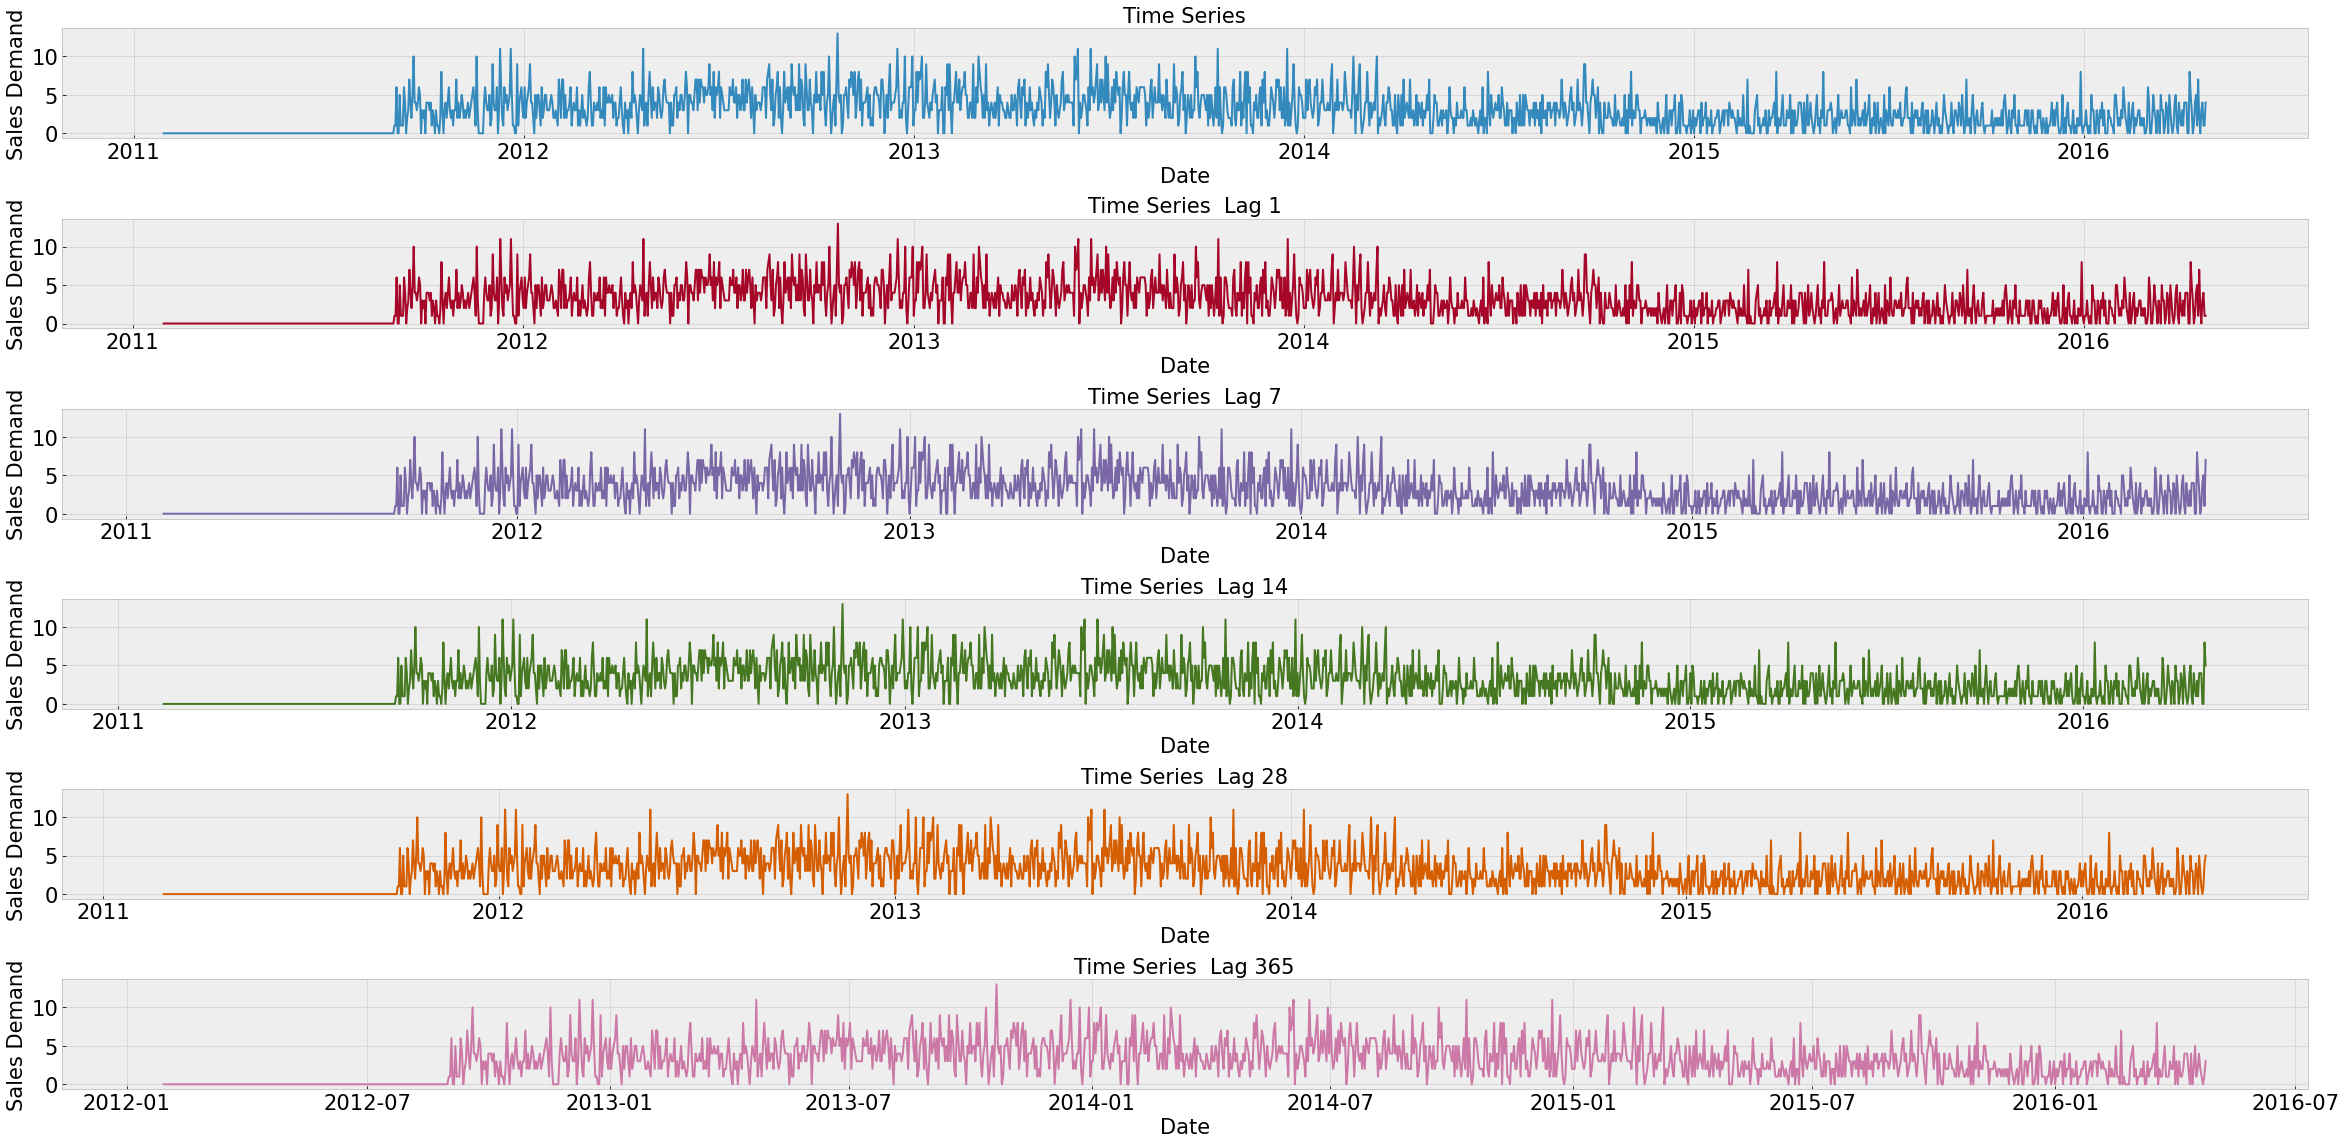

In [ ]:
DF = DF.set_index([dates_list])
Product = "Time Series"

##Create Plot 
fig, axs = plt.subplots(6, 1, figsize=(33, 16))
axs = axs.flatten()
ax_idx = 0

for i in (0,1,7,14,28,365):
    if i == 0:
        ax = DF['sales'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product)

        ax_idx += 1
    else : 
        ax = DF[f'lag_{i}'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product+f'  Lag {i}')

        ax_idx += 1
    
   
   
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )

plt.tight_layout()
plt.show()

**Rolling windows**

For rolling windows, we will use mean and std (standard deviation)

In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
2.59 min: Time for loop


,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-30,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-31,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-02,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The lags and rolling windows created Nan values When I tried to train with Nan values, the loss was also Nan Need further understanding, but for now, I will replace the Nan by zero

In [ ]:
DF = DF.replace('nan', np.nan).fillna(0)
DF.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Normalize**
Due to the multi-dimension, we need to adjust We can normalize the full Data-Frame. However, we need to do dummy normalize to our target (the sales) as our prediction will be 1D

In [ ]:
DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
DF_normlized.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-02,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


**Day Of the Week**
This article :

https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9

I have decided to try it as-is on the day of the week - So I will add four-vectors which describe the days of the week



In [ ]:
#to work on day of the week we will merge from calendar dataframe
DF_normlized = DF_normlized.reset_index()
DF_normlized = DF_normlized.rename(columns={'index':'date'})
DF_normlized.head()
DF_normlized['date'] = DF_normlized['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
DF_normlized = DF_normlized.merge(calendar[['date','weekday']],on='date')
DF_normlized.head()

,date,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365,weekday
0,2011-01-29,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Saturday
1,2011-01-30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Sunday
2,2011-01-31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Monday
3,2011-02-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Tuesday
4,2011-02-02,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Wednesday


In [ ]:
## Adding the embedded vectors 
DF_normlized['wd1'] =0
DF_normlized['wd2'] =0
DF_normlized['wd3'] =0
DF_normlized['wd4'] =0

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Sunday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Sunday']= 0.4 ,-0.3 ,0.6,0.1

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Monday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Monday']= 0.2 ,0.2 ,0.5,-0.3

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Tuesday'] ,DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Tuesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Tuesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Tuesday']= 0.1,-1.0,1.3,0.9

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Wednesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Wednesday']= -0.6,0.5,1.2,0.7

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Thursday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Thursday']= 0.9,0.2,-0.1,0.6

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Friday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Friday']= 0.4,1.1,0.3,-1.5


DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Saturday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Saturday']= 0.3,-0.2,0.6,0.0

Let's Compare one example again to verify that the normalization was done properly

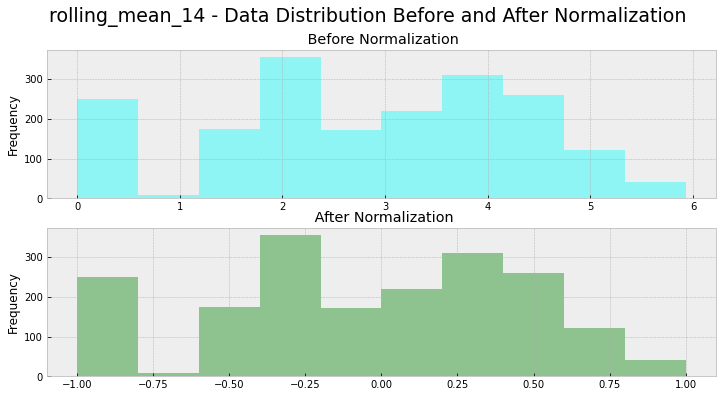

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('rolling_mean_14 - Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(DF['rolling_mean_14']).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='cyan') 
pd.DataFrame(DF_normlized['rolling_mean_14']).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'green')

**Multi dimentional sliding window**

In [ ]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
###  For Multiple features                                                            ####
def sliding_windows_mutli_features(data, seq_length):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        _x = data[i:(i+seq_length),:] ## 16 columns for features  
        _y = data[i+seq_length,0] ## column 0 contains the labbel
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y).reshape(-1,1)

In [ ]:
# Select only the features and the target for prediction  
data_with_features = DF_normlized[["sales","lag_7","lag_1","lag_28","lag_365","rolling_mean_7",\
"rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28","rolling_mean_60","rolling_std_60",'lag_28','wd1','wd2','wd3','wd4']].to_numpy()             

#data_with_features = DF_normlized['sales'].to_numpy().reshape(-1,1)
data_with_features.shape

(1913, 18)

sliding training data set

In [ ]:
x , y = sliding_windows_mutli_features(data_with_features,seq_length=28)
print("X_data shape is",x.shape)
print("y_data shape is",y.shape)

X_data shape is (1884, 28, 18)
y_data shape is (1884, 1)


**Pytorch Tensor**

In [ ]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 18])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 18])
test label shape is: torch.Size([622, 1])


**LSTM model**
The model is similar to the previous one with some enhancement at the output layers

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.2)
       
        
        
        self.fc1 = nn.Linear(hidden_size,256)
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 128)
            
        self.bn2 = nn.BatchNorm1d(128,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp2 = nn.Dropout(0.2)
        self.fc3= nn.Linear(128, 1)
        self.relu = nn.ReLU()
       
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        
        x0 = self.fc1(final_state)
        x0 = self.bn1(x0)
        x0 = self.dp1(x0)
        x0 = self.relu(x0)
        
        x0 = self.fc2(x0)
        x0 = self.bn2(x0)
        x0 = self.dp2(x0)
        
        x0 = self.relu(x0)
        
        out = self.fc3(x0)
        #print(out.size())
        return out
    

**Training**
Some enhancement we save the best model (based on the lowest validation loss)

In [ ]:
num_epochs = 500
learning_rate = 1e-3
input_size = 18
hidden_size = 512
num_layers = 4
num_classes = 1

best_val_loss = 100

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=50, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    #scheduler.step()
    
    if vall_loss.cpu().item() < best_val_loss:
         torch.save(lstm.state_dict(), 'best_model.pt')
         print("saved best model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
         best_val_loss = vall_loss.cpu().item()
        
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

saved best model epoch: 0 val loss is: 0.5595623254776001
Epoch: 0, loss: 0.42431 valid loss:  0.55956 
saved best model epoch: 1 val loss is: 0.5511404275894165
saved best model epoch: 2 val loss is: 0.5425507426261902
saved best model epoch: 3 val loss is: 0.5340645909309387
saved best model epoch: 4 val loss is: 0.5255821347236633
saved best model epoch: 5 val loss is: 0.5173442959785461
saved best model epoch: 6 val loss is: 0.5095977187156677
saved best model epoch: 7 val loss is: 0.5024738907814026
saved best model epoch: 8 val loss is: 0.493945837020874
saved best model epoch: 9 val loss is: 0.484077125787735
saved best model epoch: 10 val loss is: 0.4747134745121002
saved best model epoch: 11 val loss is: 0.4674012362957001
saved best model epoch: 12 val loss is: 0.4588977098464966
saved best model epoch: 13 val loss is: 0.4524758458137512
saved best model epoch: 14 val loss is: 0.44496476650238037
saved best model epoch: 15 val loss is: 0.4323582351207733
saved best model epoc

(1884, 1)
(1884, 1)


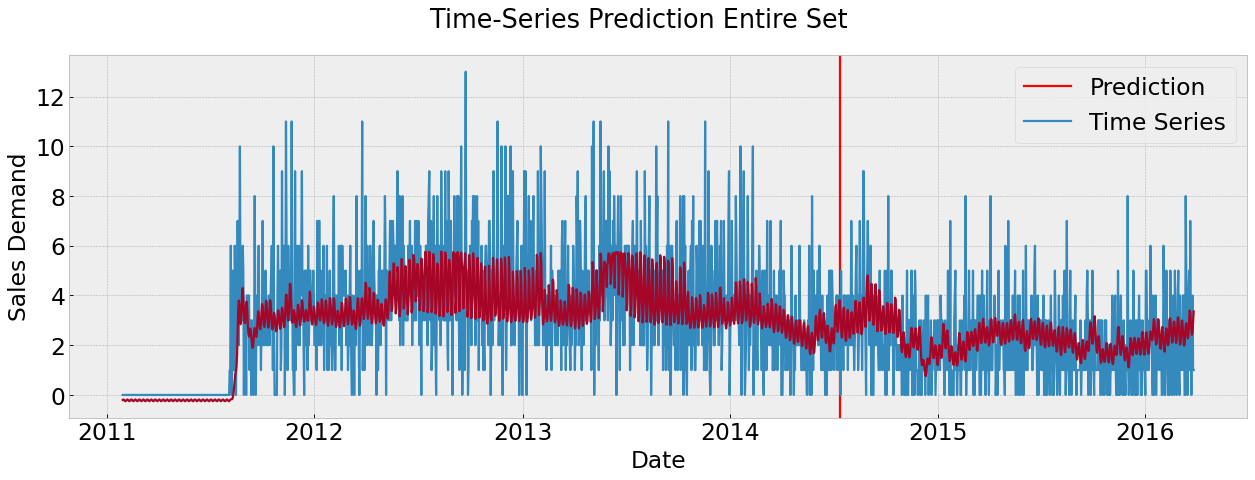

In [ ]:
######Prediction###############
lstm.load_state_dict(torch.load('best_model.pt'))

lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()
print(data_predict.shape)
print(dataY_plot.shape)


## Inverse Normalize 
data_predict = y_scaler.inverse_transform(data_predict)
dataY_plot = y_scaler.inverse_transform(dataY_plot.reshape(-1, 1))

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

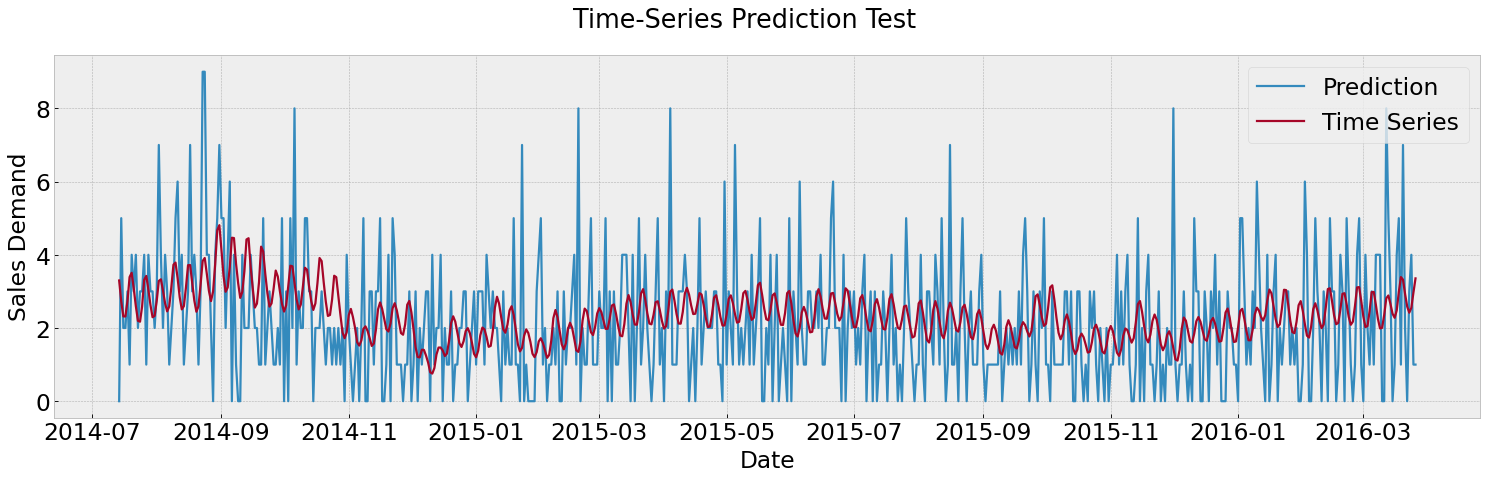

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

**RMSE**

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

1.6729103